# Time Series Forecasting of the SP 500

Summary: 

There are a ton of [videos](https://www.youtube.com/results?search_query=neural+network+stock+price) and [articles](https://www.google.com/search?client=firefox-b-1-d&q=neural+network+stock+price) dedicated to using nerual networks for stock price predition.  I intend to show that, while the results from these models can look compelling, they need to be taken with a ton of skepticism.

This notebook will use a few simple neural networks to predict the future price of the SP500.  From these models, the price prediction accuracy was no different -- and in some cases worse than -- the accuracy of the baseline.  (The baseline for predicted price was the previous day's closing price.)  Price prediction, such as for stocks, is extremely difficult based upon the [efficent market hypothesis](https://en.wikipedia.org/wiki/Efficient-market_hypothesis).  The purpose, therefore, of this notebook is a demonstration of time series forecasting using machine learning; splitting the data into train and test sets, putting the data into windows, creating models, and evaluating them; and also to show how unreliable the predicted results can be for such complex, open systems.  I will show predictions from data going to June 2022.  I will also show a machine learning model could not predict Black Monday, when the SP500 fell by 20% in a single day.

Outline of the notebook:

    1. Problem Statement
    2. Data Source
    3. Evaluation Metrics
    4. Data Analysis
    5. Modeling Data and Results
    6. Conclusions

## 1. Problem Statement

Use a few simple neural networks to predict the price of the SP500.  I will show that despite these models looking very pormising, the results can be decieving.

## 2. Data

Data for the SP500 was collected from VFINX (Vanguard's SP500 mutual fund).  The data sourse was [Yahoo Finance](https://finance.yahoo.com/quote/VFINX/).  All price predictions are based on the closing price.

## 3. Evaluation Metrics

Using the previous day's closing price as our prediction baseline; that is, yesterday's closing price is today's predicted value, I will attempt to see if machine learning can have better accuracy.

## 4. Data Analysis

In [42]:
import pandas as pd

"""
Note: for the location of the data used, please refer to the data folder of this project
"""

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/VFINX Data/VFINX price history.csv",
                 parse_dates=["Date"],
                 index_col = ["Date"])
print(df.describe())
print(df.head())


               Open          High           Low         Close     Adj Close  \
count  10712.000000  10712.000000  10712.000000  10712.000000  10712.000000   
mean     108.818196    108.818196    108.818196    108.818196     88.387983   
std       90.951513     90.951513     90.951513     90.951513     92.304776   
min       13.160000     13.160000     13.160000     13.160000      4.410861   
25%       33.820000     33.820000     33.820000     33.820000     16.895686   
50%       99.150002     99.150002     99.150002     99.150002     68.933506   
75%      133.975002    133.975002    133.975002    133.975002    103.682308   
max      442.670013    442.670013    442.670013    442.670013    441.334442   

        Volume  
count  10712.0  
mean       0.0  
std        0.0  
min        0.0  
25%        0.0  
50%        0.0  
75%        0.0  
max        0.0  
             Open   High    Low  Close  Adj Close  Volume
Date                                                     
1980-01-02  14.34  

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10712 entries, 1980-01-02 to 2022-06-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       10712 non-null  float64
 1   High       10712 non-null  float64
 2   Low        10712 non-null  float64
 3   Close      10712 non-null  float64
 4   Adj Close  10712 non-null  float64
 5   Volume     10712 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 585.8 KB


In [44]:
# Number of datapoints
len(df)

10712

In [45]:
# Use closing price to build forecasting model
sp500_prices = pd.DataFrame(df["Close"]).rename(columns={"Close": "Price"})
sp500_prices.head()

,Price
Date,
1980-01-02,14.34
1980-01-03,14.27
1980-01-04,14.45
1980-01-07,14.49
1980-01-08,14.78


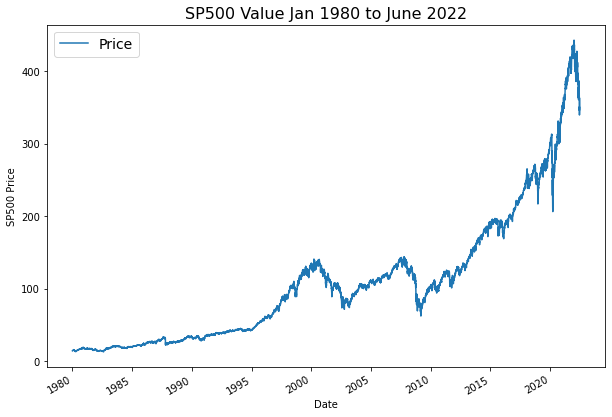

In [46]:
import matplotlib.pyplot as plt
sp500_prices.plot(figsize=(10, 7))
plt.ylabel("SP500 Price")
plt.title("SP500 Value Jan 1980 to June 2022", fontsize=16)
plt.legend(fontsize=14);

In [47]:
# Importing and formatting data
import csv
from datetime import datetime

timesteps = []
sp500_price = []
with open("/content/drive/MyDrive/Colab Notebooks/VFINX Data/VFINX price history.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
  next(csv_reader) # skip line 1
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[0], "%Y-%m-%d")) # get the dates 
    sp500_price.append(float(line[1])) # get the closing price as float

# View first 5 of each
timesteps[:5], sp500_price[:5]

([datetime.datetime(1980, 1, 2, 0, 0),
  datetime.datetime(1980, 1, 3, 0, 0),
  datetime.datetime(1980, 1, 4, 0, 0),
  datetime.datetime(1980, 1, 7, 0, 0),
  datetime.datetime(1980, 1, 8, 0, 0)],
 [14.34, 14.27, 14.45, 14.49, 14.78])

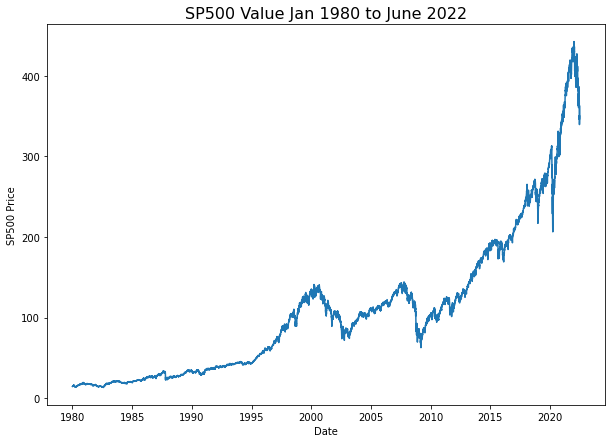

In [48]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, sp500_price)
plt.title("SP500 Value Jan 1980 to June 2022", fontsize=16)
plt.xlabel("Date")
plt.ylabel("SP500 Price");

In [ ]:
# Create date array and normalize price values

scale = 442.67 # high price; used for normalizing price values
timesteps = sp500_prices.index.to_numpy()
prices = sp500_prices["Price"].to_numpy()/scale

timesteps[:5], prices[:5]

In [50]:
# Create train/test splits for the data using 90% train and 10% test

from sklearn.model_selection import train_test_split 


split_size = int(0.9 * len(prices)) # 90% train, 10% test

# Create train data splits
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(9640, 1072, 9640, 1072)

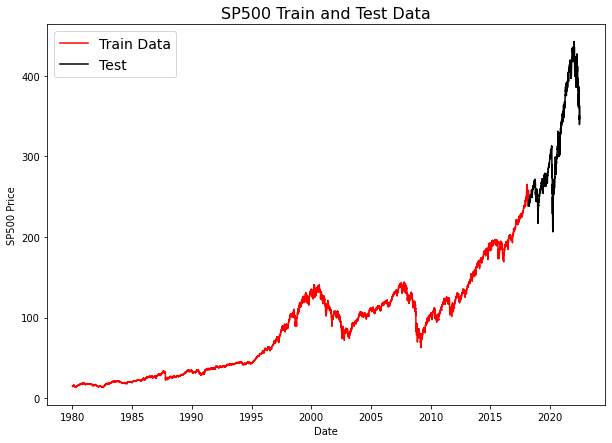

In [51]:
# Rescale results for plotting
y_train_plot = y_train * scale
y_test_plot = y_test * scale

# Plot train/test splits
plt.figure(figsize=(10, 7))
plt.plot(X_train, y_train_plot, label="Train Data",color="red")
plt.plot(X_test, y_test_plot, label="Test",color="black")
plt.xlabel("Date")
plt.ylabel("SP500 Price")
plt.title("SP500 Train and Test Data", fontsize=16)
plt.legend(fontsize=14);


These will be our train and test splits.

## Baseline: Simple model using previous closing price

In [52]:
baseline = y_test[:-1] # previous day's closing price for the predicted value
baseline[:5], baseline[-5:] # View frist 5 and last 5 values

(array([0.53970227, 0.5543407 , 0.54476245, 0.54327152, 0.55077145]),
 array([0.76718545, 0.76890233, 0.78774254, 0.78672603, 0.79427114]))

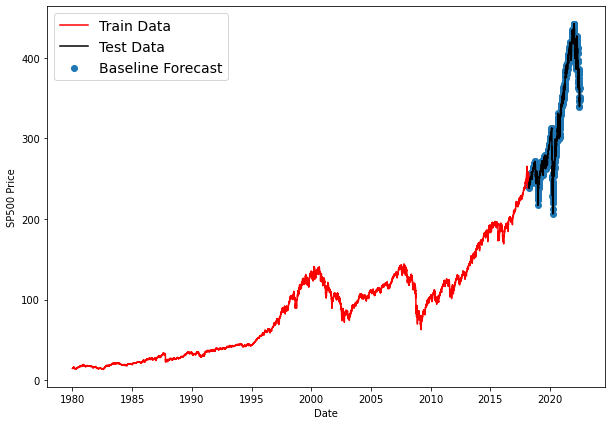

In [53]:
# Baseline forecast

# Rescale results for plotting
y_train_plot = y_train * scale
y_test_plot = y_test * scale

plt.figure(figsize=(10, 7))
plt.plot(X_train, y_train_plot, label="Train Data",color="red")
plt.plot(X_test, y_test_plot, label="Test Data",color="black")
plt.scatter(X_test[1:], y_test_plot[1:], label="Baseline Forecast")
plt.legend(fontsize=14);
plt.xlabel("Date")
plt.ylabel("SP500 Price");

Text(0.5, 1.0, 'SP500 Test Data vs Baseline Forecast')

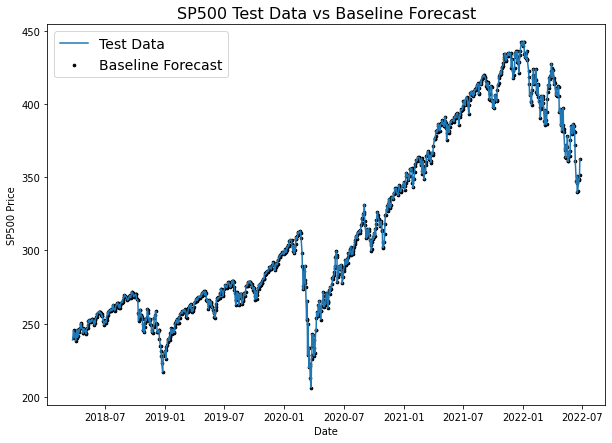

In [54]:
# Closer look at baseline forecast

plt.figure(figsize=(10, 7))
plt.plot(X_test, y_test_plot, label="Test Data")
plt.scatter(X_test[1:], y_test_plot[1:], label="Baseline Forecast", color="black",s=7)
plt.legend(fontsize=14);
plt.xlabel("Date")
plt.ylabel("SP500 Price");
plt.title("SP500 Test Data vs Baseline Forecast", fontsize=16)


In [60]:
import tensorflow as tf

# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of baseline forecast 
  mae_baseline_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_baseline_no_season

In [67]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  y_true = y_true * scale # Rescale data to post results
  y_pred = y_pred * scale 


  

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [68]:
baseline_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=baseline)

baseline_results



{'mae': 2.71466,
 'mape': 0.8782461,
 'mase': 1.001298,
 'mse': 16.610565,
 'rmse': 4.0756063}

## Windowing the data

In [69]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 5  # use a previous week's worth of values for a day's prediction

In [70]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.
  """
  return x[:, :-horizon], x[:, -horizon:]

In [71]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [72]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [73]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(10707, 10707)

In [74]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [0.03239433 0.0322362  0.03264283 0.03273319 0.0333883 ] -> Label: [0.03343348]
Window: [0.0322362  0.03264283 0.03273319 0.0333883  0.03343348] -> Label: [0.03368198]
Window: [0.03264283 0.03273319 0.0333883  0.03343348 0.03368198] -> Label: [0.03368198]


In [75]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [0.78146247 0.7928931  0.76718545 0.76890233 0.78774254] -> Label: [0.78672603]
Window: [0.7928931  0.76718545 0.76890233 0.78774254 0.78672603] -> Label: [0.79427114]
Window: [0.76718545 0.76890233 0.78774254 0.78672603 0.79427114] -> Label: [0.8185556]


Turning windows into training and test datasets

In [76]:
# Make the train/test splits (90% train and 10% test)
def make_train_test_splits(windows, labels, test_split=0.1):
  """
  Splits matching pairs of windows and labels into train and test splits.
  Max_val is equal to the maximum closing price in order to normalize data between 0 and 1
  """

  max_val = 442.67 # To be used for normalization
  split_size = int(len(windows) * (1-test_split)) # this will default to 90% train/10% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [77]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(9636, 1071, 9636, 1071)

In [78]:
train_windows[:5], train_labels[:5]

(array([[0.03239433, 0.0322362 , 0.03264283, 0.03273319, 0.0333883 ],
        [0.0322362 , 0.03264283, 0.03273319, 0.0333883 , 0.03343348],
        [0.03264283, 0.03273319, 0.0333883 , 0.03343348, 0.03368198],
        [0.03273319, 0.0333883 , 0.03343348, 0.03368198, 0.03368198],
        [0.0333883 , 0.03343348, 0.03368198, 0.03368198, 0.03384011]]),
 array([[0.03343348],
        [0.03368198],
        [0.03368198],
        [0.03384011],
        [0.03406601]]))

In [79]:
# Check to see if same
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

False

### Model checkpoint function

In [80]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

## 5. Modeling Data and Results

## Model 1: Dense model (window = 5, horizon = 1)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed
tf.random.set_seed(1)

# Simple dense model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")                       
], name="model_1_dense")

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

# Fit model
model_1.fit(x=train_windows, # train windows of 5 timesteps of prices
            y=train_labels, # horizon value of 1
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

In [82]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

34/34 [==============================] - 0s 1ms/step - loss: 0.0070 - mae: 0.0070


[0.007045678328722715, 0.007045678328722715]

In [83]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

34/34 [==============================] - 0s 2ms/step - loss: 0.0063 - mae: 0.0063


[0.006255575455725193, 0.006255575455725193]

In [84]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [85]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(1071, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.545086  , 0.5515366 , 0.5490248 , 0.54554915, 0.5503387 ,
        0.5436604 , 0.5451338 , 0.5515431 , 0.5559125 , 0.5485326 ],
       dtype=float32)>)

In [86]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 2.7691555,
 'mape': 0.89038545,
 'mase': 1.0213987,
 'mse': 16.685808,
 'rmse': 4.0848265}

These results are no different than the baseline values.

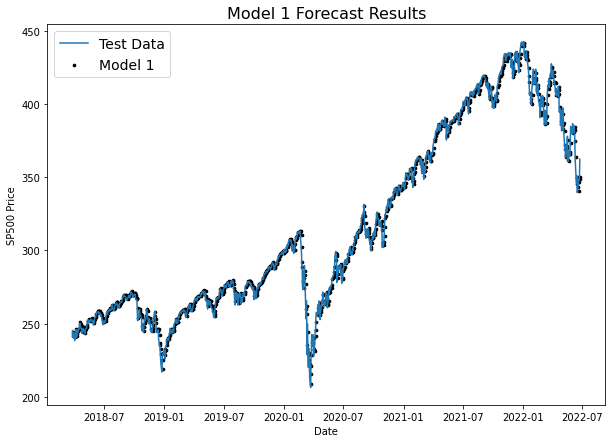

In [87]:
# Rescale data for plotting

test_labels = test_labels * scale
model_1_preds = model_1_preds * scale

# Plotting model 1 results
plt.figure(figsize=(10, 7))
plt.plot(X_test[-len(test_windows):], test_labels[:, 0], label="Test Data")
plt.scatter(X_test[-len(test_windows):], model_1_preds, label="Model 1", color="black",s=7)
plt.legend(fontsize=14);
plt.xlabel("Date")
plt.ylabel("SP500 Price")
plt.title("Model 1 Forecast Results", fontsize=16);

## Model 2: Dense (window = 10, horizon = 1)

In [88]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 10 # use 2x weeks worth of data for the next prediction

Instead of using the previous five trading days, I'll extend the timeframe out to the previous ten trading days to use for my forecasted value.

In [89]:


# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(10702, 10702)

In [90]:
# Make train and testing windows (90% train/10% test)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(9631, 1071, 9631, 1071)

In [ ]:
tf.random.set_seed(1)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [92]:
# Evaluate model 2
model_2.evaluate(test_windows, test_labels)

34/34 [==============================] - 0s 1ms/step - loss: 0.0071


0.0071344636380672455

In [93]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

34/34 [==============================] - 0s 2ms/step - loss: 0.0063


0.006340204272419214

In [94]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

In [95]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 2.806618,
 'mape': 0.9028726,
 'mase': 1.0352166,
 'mse': 17.500393,
 'rmse': 4.183347}

Again, there isn't too much difference between these values and the baseline results.  It is starting to appear that using the previous day's closing value is a somewhat decent price predictor for the next trading day.

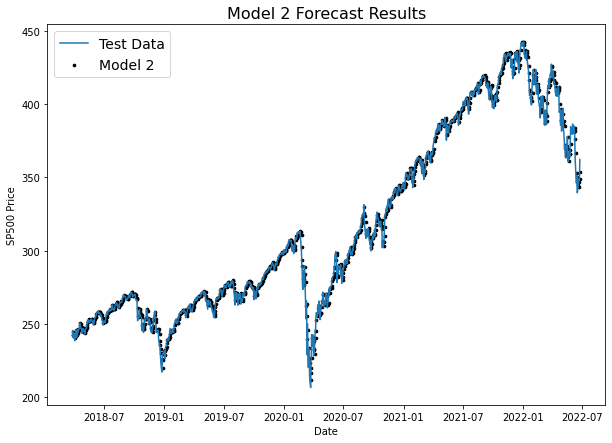

In [96]:
# Rescale data for plotting

test_labels = test_labels * scale
model_2_preds = model_2_preds * scale

# Plot Model 2 Results

plt.figure(figsize=(10, 7))
plt.plot(X_test[-len(test_windows):], test_labels[:, 0], label="Test Data")
plt.scatter(X_test[-len(test_windows):], model_2_preds, label="Model 2", color="black",s=7)
plt.legend(fontsize=14);
plt.xlabel("Date")
plt.ylabel("SP500 Price")
plt.title("Model 2 Forecast Results", fontsize=16);

##Model 3: Dense with window of 15, horizon = 5

In [114]:
HORIZON = 5 # predict a week ahead
WINDOW_SIZE = 15 # use 3 weeks of previous data

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(10693, 10693)

I will now use the previous 15 trading days to predict a price five days out.

In [115]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.1)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(9623, 1070, 9623, 1070)

In [ ]:
tf.random.set_seed(1)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [117]:
#ow did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

34/34 [==============================] - 0s 1ms/step - loss: 0.0105


0.010533849708735943

In [118]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

34/34 [==============================] - 0s 1ms/step - loss: 0.0105


0.010533849708735943

In [122]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  y_true = y_true * scale # Rescale data to post results
  y_pred = y_pred * scale 


  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [123]:
# The predictions are going to be 5 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)

model_3_preds

<tf.Tensor: shape=(1070, 5), dtype=float32, numpy=
array([[0.5702111 , 0.5726216 , 0.57460463, 0.5754558 , 0.57421434],
       [0.56911445, 0.57298046, 0.5748484 , 0.57480687, 0.57421684],
       [0.5620521 , 0.5645144 , 0.56628406, 0.5670076 , 0.56702733],
       ...,
       [0.7917994 , 0.8008107 , 0.80013525, 0.80587304, 0.80299103],
       [0.7913346 , 0.79883486, 0.80113673, 0.80054057, 0.8004979 ],
       [0.7765158 , 0.7744005 , 0.78564286, 0.78358597, 0.7855204 ]],
      dtype=float32)>

In [124]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)

model_3_results

{'mae': 4.663019,
 'mape': 1.509049,
 'mase': 1.7217132,
 'mse': 51.1024,
 'rmse': 5.2491684}

The error in these predicted values is about double that of the baseline.  This result makes sense as the further out you go -- and using more data to forecast your predicted value -- will cause a greater dispersion in outcomes.  Therefore, the more data used for your prediction -- and the further out one goes -- will produce a result with a much greater dispersion.

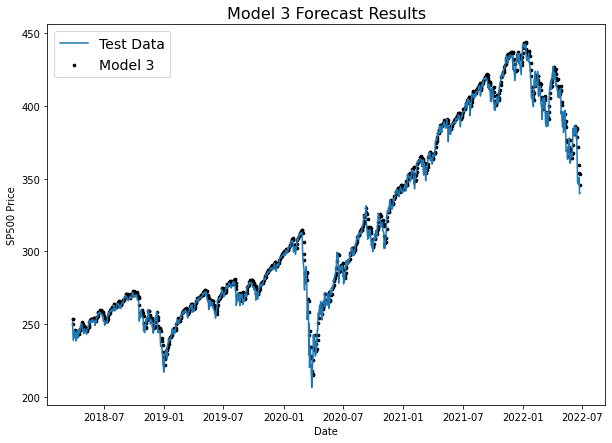

In [105]:
# Rescale data for plotting

test_labels = test_labels * scale
model_3_preds = model_3_preds * scale

# Plot Model 3 Results

plt.figure(figsize=(10, 7))
plt.plot(X_test[-len(test_windows):], test_labels[:, 0], label="Test Data")
plt.scatter(X_test[-len(test_windows):], tf.reduce_mean(model_3_preds, axis=1), label="Model 3", color="black",s=7)
plt.legend(fontsize=14);
plt.xlabel("Date")
plt.ylabel("SP500 Price")
plt.title("Model 3 Forecast Results", fontsize=16);

## Model 4: Conv1D (window = 5, horizon = 1)

In [125]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 5 # use previous week worth of data

I'll now use a simple convolutional neural network looking back at the previous five trading days to forecast tomorrow's closing price.

In [126]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(10707, 10707)

In [127]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(9636, 1071, 9636, 1071)

In [128]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(5,)

In [129]:
# reshape data in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (5,)
Expanded shape: (5, 1)
Original values with expanded shape:
 [[0.03239433]
 [0.0322362 ]
 [0.03264283]
 [0.03273319]
 [0.0333883 ]]


In [ ]:
tf.random.set_seed(1)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [131]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 5)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            3328      
                                                                 
 dense_8 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 3,457
Trainable params: 3,457
Non-trainable params: 0
_________________________________________________________________


In [132]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

34/34 [==============================] - 0s 1ms/step - loss: 0.0064


0.006401910912245512

In [133]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)

# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 2.8339345,
 'mape': 0.9120744,
 'mase': 1.0452923,
 'mse': 17.585657,
 'rmse': 4.193526}

These results are very similiar to the previous results reported as well as the baseline.  Again, not too much of a difference despite using a more complex technique.

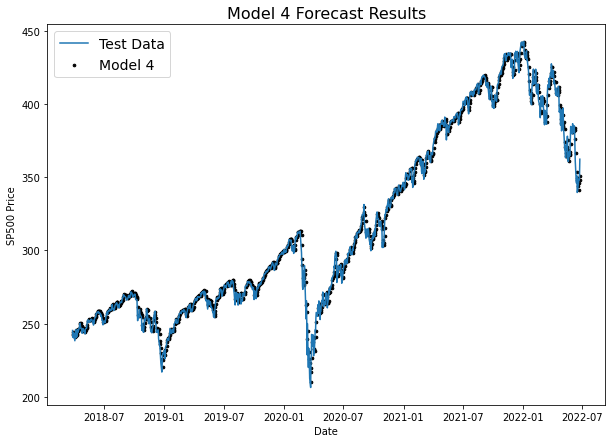

In [134]:
# Rescale data for plotting

test_labels = test_labels * scale
model_4_preds = model_4_preds * scale

# Plot Model 4 Results

plt.figure(figsize=(10, 7))
plt.plot(X_test[-len(test_windows):], test_labels[:, 0], label="Test Data")
plt.scatter(X_test[-len(test_windows):], model_4_preds, label="Model 4", color="black",s=7)
plt.legend(fontsize=14);
plt.xlabel("Date")
plt.ylabel("SP500 Price")
plt.title("Model 4 Forecast Results", fontsize=16);

## Model 5: Recurrent Neural Network (Long Short Term Memory; window = 5, horizon = 1))

For my last model, I will use a recurrent neural network with the previous five trading days to predict today's price.

In [ ]:
tf.random.set_seed(1)

#Rescale

test_labels = test_labels/scale

# LSTM model w/ the functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
x = layers.LSTM(128, activation="relu")(x) 
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [148]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

34/34 [==============================] - 0s 2ms/step - loss: 0.0083


0.008340030908584595

In [149]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)

# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 3.691882,
 'mape': 1.1433547,
 'mase': 1.3617448,
 'mse': 27.588955,
 'rmse': 5.252519}

These results are no different than the previous models mentioned.  What is most impressive with these results is that they're off by a few dollars when the stock is trading up to $400.

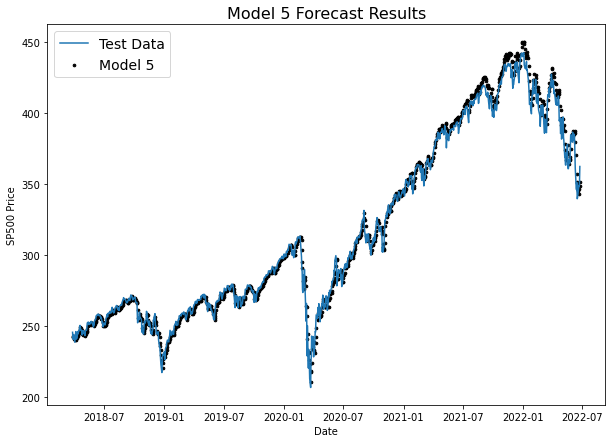

In [150]:
# Plot Model 5 Results

#Rescale

test_labels = test_labels * scale
model_5_preds = model_5_preds * scale

plt.figure(figsize=(10, 7))
plt.plot(X_test[-len(test_windows):], test_labels[:, 0], label="Test Data")
plt.scatter(X_test[-len(test_windows):], model_5_preds, label="Model 5", color="black",s=7)
plt.legend(fontsize=14);
plt.xlabel("Date")
plt.ylabel("SP500 Price")
plt.title("Model 5 Forecast Results", fontsize=16);

## Model Result Summary

In [151]:
# Compare different model results (w = window, h = horizon)
model_results = pd.DataFrame({"baseline": baseline_results,
                              "model_1_dense_w5_h1": model_1_results,
                              "model_2_dense_w10_h1": model_2_results,
                              "model_3_dense_w15_h5": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results}).T
model_results.head(6)

,mae,mse,rmse,mape,mase
baseline,2.714660,16.610565,4.075606,0.878246,1.001298
model_1_dense_w5_h1,2.769156,16.685808,4.084826,0.890385,1.021399
model_2_dense_w10_h1,2.806618,17.500393,4.183347,0.902873,1.035217
model_3_dense_w15_h5,4.663019,51.102402,5.249168,1.509049,1.721713
model_4_CONV1D,2.833935,17.585657,4.193526,0.912074,1.045292
model_5_LSTM,3.691882,27.588955,5.252519,1.143355,1.361745


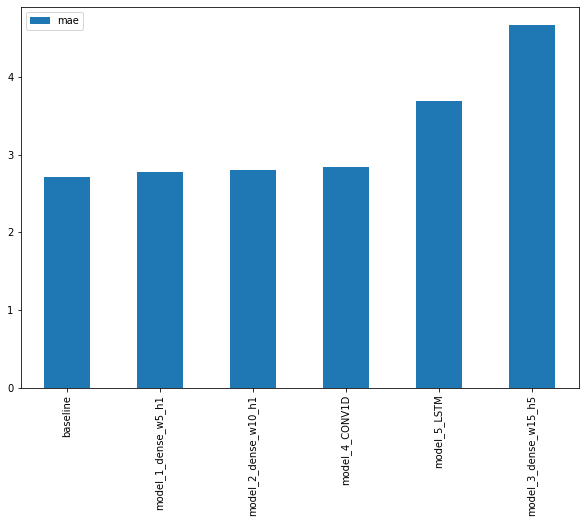

In [152]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");

All of the models, excluding model 3 (the model making a further out forecast), have a similar error values to the baseline forecast.  All of these models, however, look to be very accurate given their fit to the test data.  (There only a few dollars off a stock trading for hundreds of dollars.)  This can, however, be a bit deceiving.  Below, I will use model 1 to see if it can forecast a 20% price drop.  This actually happened to the stock market on a day known as [Black Monday](https://en.wikipedia.org/wiki/Black_Monday_(1987)).

## Checking Black Monday (October 17, 1987)

There was a 20% drop in the SP500 in a single day!  I want to test other areas of the data to see if sudden price drops can be predicted.  Will be using model 1 given it has the best accuracy.  I will split my data into train/test sets and use the previous closing price of five days to determine my predicted value.

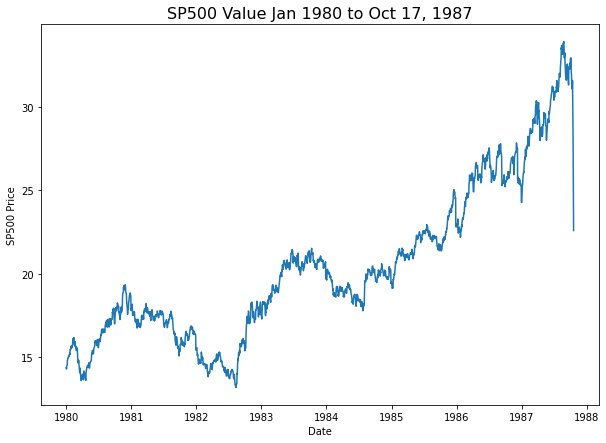

In [154]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np

black_monday_prices = prices[:1972]
black_monday_timesteps = timesteps[:1972]

black_monday_prices_plot = black_monday_prices * scale

plt.figure(figsize=(10, 7))
plt.plot(black_monday_timesteps, black_monday_prices_plot)
plt.title("SP500 Value Jan 1980 to Oct 17, 1987", fontsize=16)
plt.xlabel("Date")
plt.ylabel("SP500 Price");

Displayed is the SP500 from 1980 to Oct 17, 1987.  As you can see, there's quite a precipitous drop at the last data point.

In [155]:
# Create train and test sets to model Black Monday (90% train/10% test)


HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 5 # use a week worth of timesteps to predict the horizon



full_windows, full_labels = make_windows(np.array(black_monday_prices), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)



(1770, 197, 1770, 197)

## Modeling Black Monday with Model 1

In [ ]:
# Using model 1 for test since had best accuracy
black_monday_model = tf.keras.models.clone_model(model_1)
black_monday_model._name = "Black_Monday_Model"
black_monday_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())
black_monday_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(black_monday_model.name)])



In [157]:
# Evaluate model
black_monday_model.evaluate(X_test, y_test)



7/7 [==============================] - 0s 2ms/step - loss: 8.4602e-04


0.0008460185490548611

In [158]:
# Load best model and evaluate on test data
black_monday_model = tf.keras.models.load_model("model_experiments/Black_Monday_Model/")
black_monday_model.evaluate(X_test, y_test)



7/7 [==============================] - 0s 2ms/step - loss: 7.5823e-04


0.0007582312682643533

In [159]:
# Make predictions
black_monday_preds = make_preds(black_monday_model, X_test)
black_monday_preds[-10:]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.07442596, 0.07357536, 0.07301378, 0.07219324, 0.07146894,
       0.07082473, 0.07109896, 0.07027012, 0.06903698, 0.06662771],
      dtype=float32)>

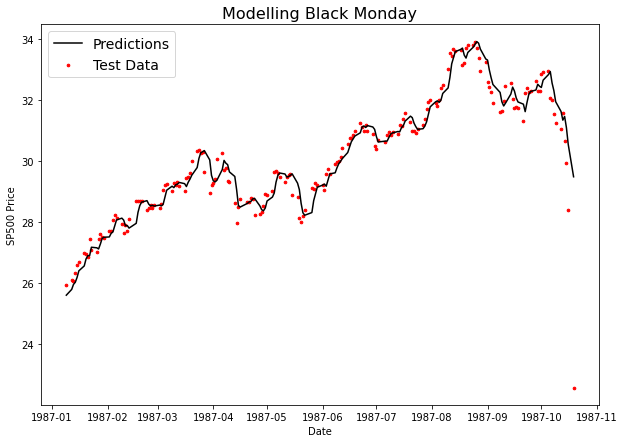

In [160]:
# Plot from CSV

black_monday_preds = black_monday_preds * scale # Rescale data to reflect dollars

import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.scatter(black_monday_timesteps[-197:], black_monday_prices_plot[-197:], label="Test Data",color="red", s=7)
plt.plot(black_monday_timesteps[-197:], black_monday_preds, label="Predictions",color="black")
plt.title("Modelling Black Monday", fontsize=16)
plt.xlabel("Date")
plt.ylabel("SP500 Price")
plt.legend(fontsize=14);

From the results, predeicted value for Black Monday, Oct 17, 1987, was 28.94 despite the actual closing value that day of 22.58.  In my conclusions I will state why price prediction for stocks is very difficult and can be unreliable given the accuracy of the models in earlier predictions.

# 6. Conclusions

From observing the last few data points for modeling Black Monday, the model has poor predictive capabilities.  A model cannot predict anything in the future outside of the distribution of data used for training.  Therefore, larger, unexpected price movements upward or downward will likely never be part of a forecast.  These price prediction models are just highly mathematical [technical analysis](https://en.wikipedia.org/wiki/Technical_analysis) models; this style of analysis has been debunked based upon the [efficient market hypothesis](https://en.wikipedia.org/wiki/Efficient-market_hypothesis).  Price predictions such as this are extremely difficult.  [A Random Walk Down Wall Street](https://www.amazon.com/Random-Walk-Down-Wall-Street/dp/0393358380/ref=sr_1_1?keywords=a+random+walk+down+wall+street&qid=1657044738&sprefix=a+random+walk%2Caps%2C182&sr=8-1) and the [Fama Portfolio ](https://www.amazon.com/Fama-Portfolio-Selected-Papers-Eugene/dp/022642684X/ref=sr_1_1?crid=KP8YKVA9VG96&keywords=the+fama+portfolio&qid=1657044728&sprefix=the+fama+portoflio%2Caps%2C178&sr=8-1) are great books dealing with this subject matter.  The models employed are no better -- and sometimes worse -- than using the previous day's closing price as your predicted price.  Time series forecasts has been used in pattern recognition, weather forecasting, earthquake prediction, and many [more fields](https://en.wikipedia.org/wiki/Time_series), however, with better results.  While we will most likely never see a drop of 20% again in the SP500 due to [circuit breakers](https://personal.vanguard.com/us/content/Funds/FundsToolsCircuitBreakersJSP.jsp) now in place, this doesn't hold for individual stocks.  The SP500 has, historically, had a yearly standard deviation of roughly 15.8%.  Individual stocks, [for example Tesla](https://www.portfoliovisualizer.com/backtest-portfolio?s=y&timePeriod=4&startYear=1985&firstMonth=1&endYear=2022&lastMonth=12&calendarAligned=true&includeYTD=false&initialAmount=10000&annualOperation=0&annualAdjustment=0&inflationAdjusted=true&annualPercentage=0.0&frequency=4&rebalanceType=1&absoluteDeviation=5.0&relativeDeviation=25.0&leverageType=0&leverageRatio=0.0&debtAmount=0&debtInterest=0.0&maintenanceMargin=25.0&leveragedBenchmark=false&reinvestDividends=true&showYield=false&showFactors=false&factorModel=3&portfolioNames=false&portfolioName1=Portfolio+1&portfolioName2=Portfolio+2&portfolioName3=Portfolio+3&symbol1=TSLA&allocation1_1=100&symbol2=VFINX&allocation2_2=100), can have yearly standard deviations of over 60!  Smaller stocks can have even greater values making price prediction an impossible feat.

# Side Note

An interesting book to read is ["The Man Who Solved the Market"](https://www.amazon.com/s?k=jim+simons&crid=1W1QWSDMK4IY5&sprefix=jim+simons%2Caps%2C255&ref=nb_sb_noss_1).  It's about the mathematician [Jim Simons](https://en.wikipedia.org/wiki/Jim_Simons_(mathematician)) and his hedge fund [Renaissance Technologies](https://en.wikipedia.org/wiki/Renaissance_Technologies).  Synopsis: with 200+ PhDs at this fund, they're able to create machine learning models that work with arbitrage strategies for fixed income assests based on patterns that last for a few days.  For the personal fund not available to the public, they've compounded it by 39% annually by incorporating a ton of leverage.  However, the fund is limited to only a few billion in size for their techniques to work.  Given that the global fixed income market is roughly 124 trillion ([link, page 8](https://www.sifma.org/wp-content/uploads/2021/07/CM-Fact-Book-2021-SIFMA.pdf)) in size, they've found a way to roughly get 8E-4% annually from these markets.  This is impressive feat for this hedge fund, but is also a testament to the efficieny of markets.